# 주식 예측에 도전해보자.

In [201]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.3
1.1.1
0.13.2


먼저 삼성전자에 대한 주식 시세를 예측해보자.

[ 야후 파이낸스 ](https://finance.yahoo.com/?guccounter=1&guce_referrer=aHR0cHM6Ly9sbXMuYWlmZmVsLmlvLw&guce_referrer_sig=AQAAANRLWHasDEVtlb-wJZabGszH0XT8tipR_3xty73cFq81UP_4OPQHjXZQkIuiT3p5k_hU634Zr25D9iOELvnIsyZRvygSPKkm5JJhcE-6xhBbjcT88oXAx7GqPeAY8GhrxmgtJe4Del5xAyCXlC5NauI0K_cdqumwYS3yViCpZG1U)에서 주식 종목 데이터셋을 받아볼 수 있다.

## Step 1 : 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
df_samsung = pd.read_csv('./data/005930.KS.csv', index_col='Date', parse_dates=True)

ts = df_samsung['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

- 결측치 처리
- 로그 변환


### 결측치 처리

In [203]:
ts = ts.interpolate(method = "time")
ts[ts.isna()].size

0

### 로그변환

In [204]:
ts_log = np.log(ts)

## Step 3: 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [205]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

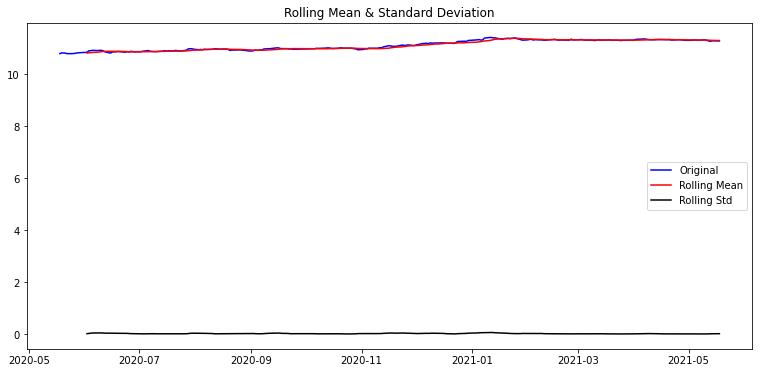

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


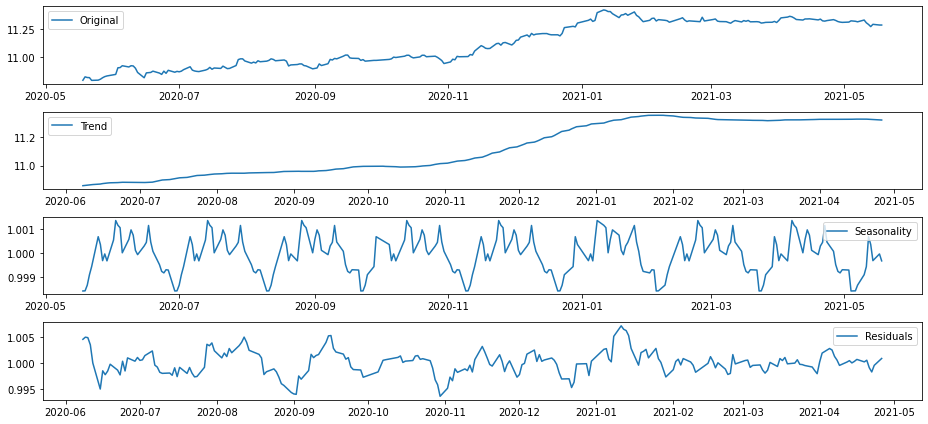

In [206]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [207]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


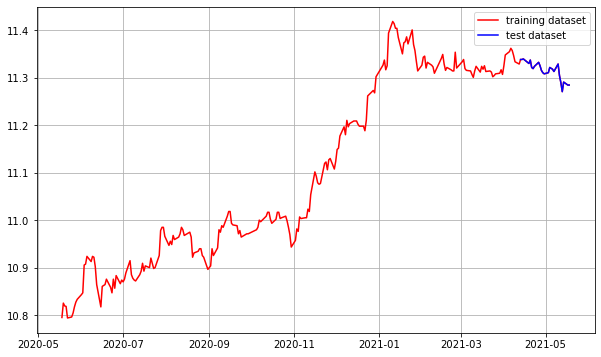

In [208]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

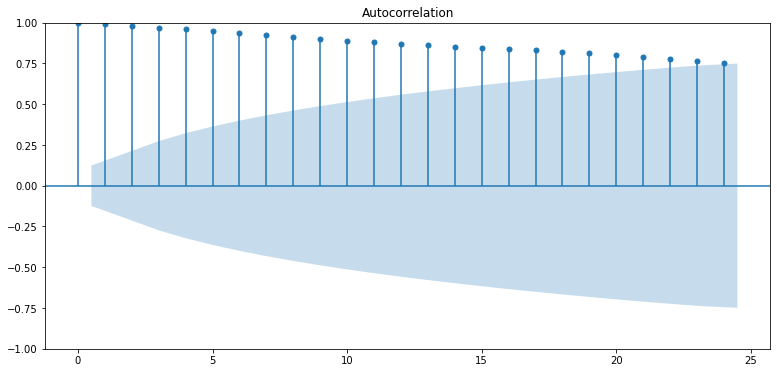

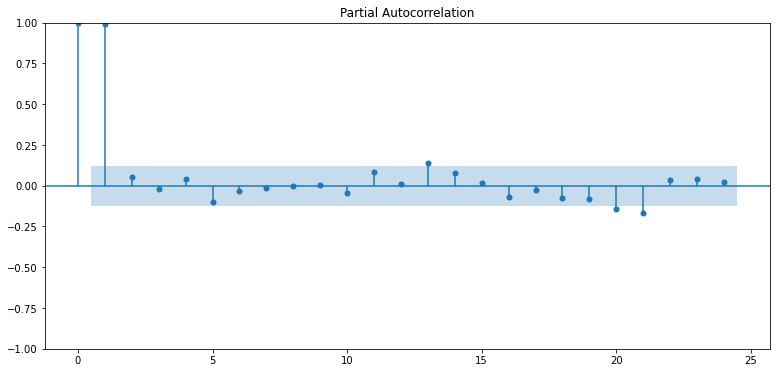

In [209]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


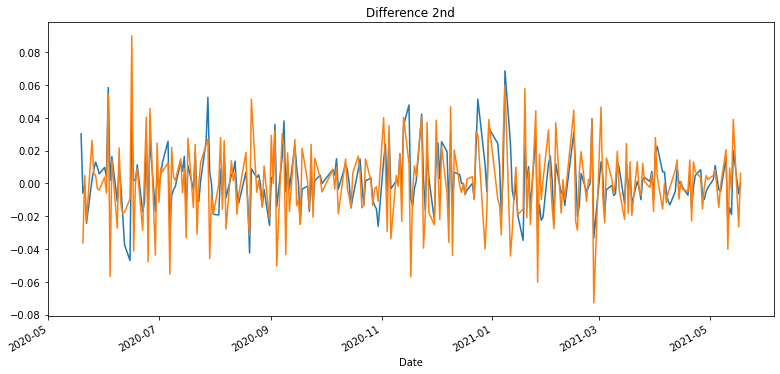

In [210]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [211]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Fri, 30 Sep 2022   AIC                          -1156.722
Time:                        13:27:13   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

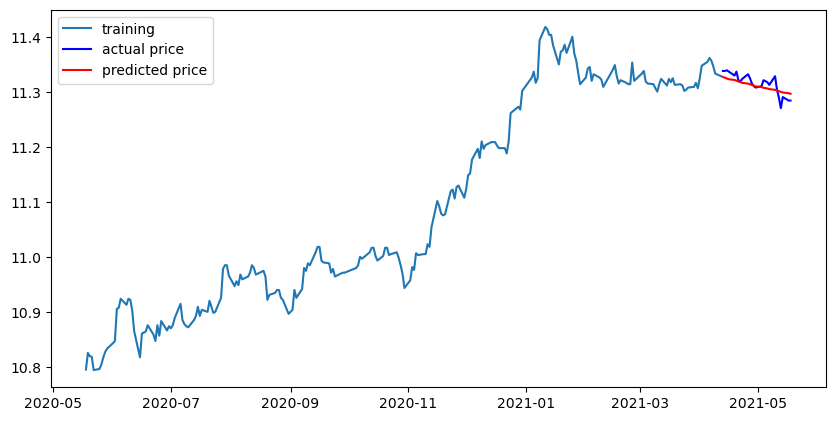

In [212]:

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [213]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014240377
MAE:  843.7579531507491
RMSE:  1024.194122920083
MAPE: 1.03%


삼성전자는 예측과 1%의 평균오차율을 보이며, 우수한 예측으로 평가받았다.

# Cloudflare도 예측해보자.

## Step1. 시계열 데이터 준비


In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
df_cloudflare = pd.read_csv('./data/NET.csv', index_col='Date', parse_dates=True)

ts_cf = df_cloudflare['Close']

ts_cf.head()

Date
2021-09-29    112.339996
2021-09-30    112.650002
2021-10-01    114.980003
2021-10-04    115.730003
2021-10-05    125.589996
Name: Close, dtype: float64

## Step2. 각종 전처리

### 결측치 처리

In [215]:
ts_cf = ts_cf.interpolate(method = "time")
ts_cf[ts_cf.isna()].size

0

### 로그변환

In [216]:
ts_cf_log = np.log(ts_cf)

## Step3. 시계열 안정성 분석

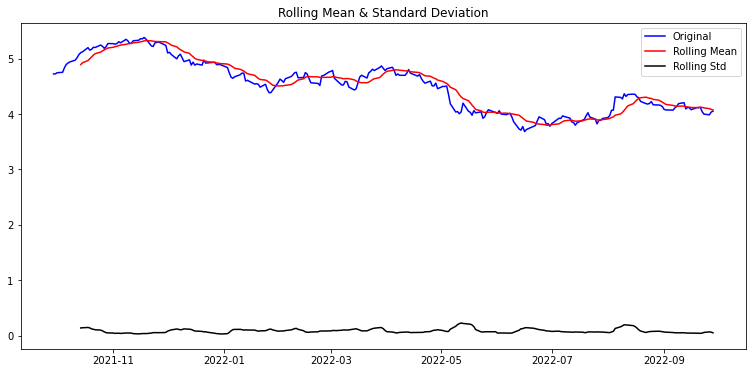

Results of Dickey-Fuller Test:
Test Statistic                  -0.810740
p-value                          0.815947
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


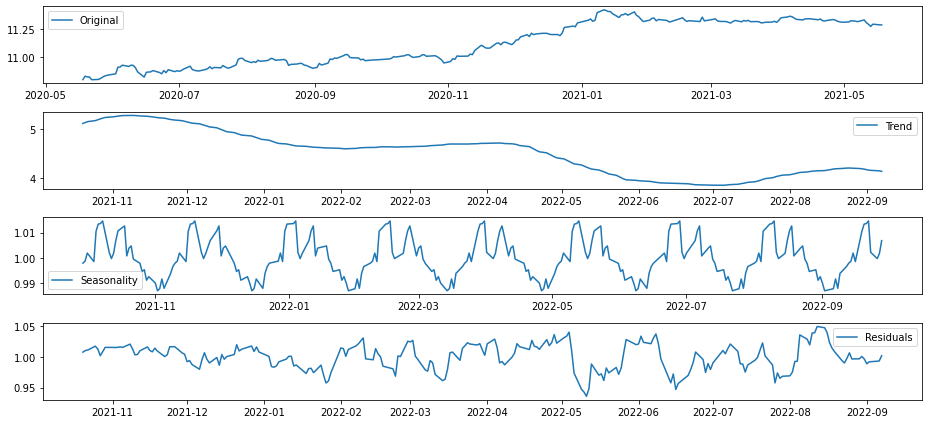

In [217]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_cf_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_cf_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_cf_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [218]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.538145
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


## Step4. Train, Test 데이터셋 생성

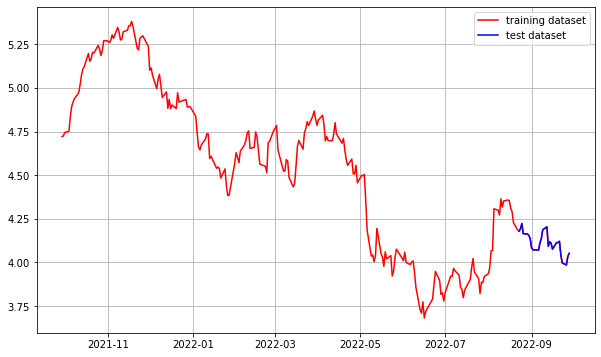

In [219]:
train_data, test_data = ts_cf_log[:int(len(ts_cf_log)*0.9)], ts_cf_log[int(len(ts_cf_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_cf_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## Step5. 적정 ARIMA 모수 찾기

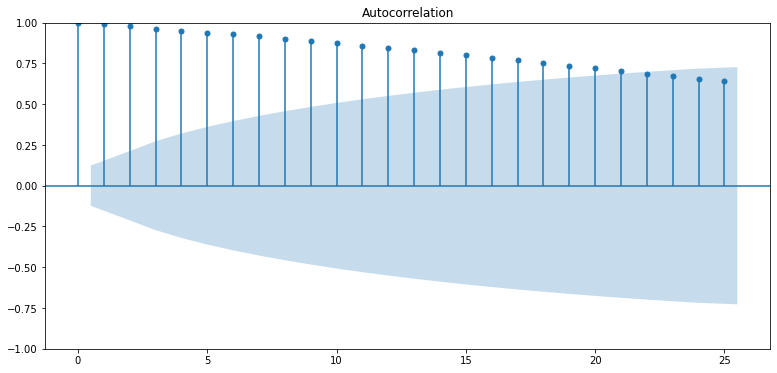

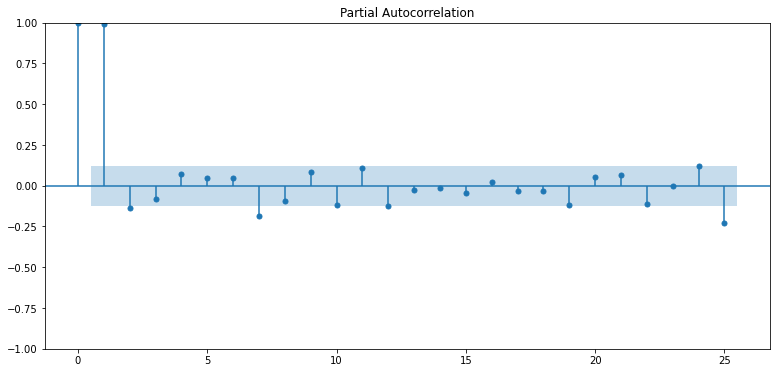

In [220]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_cf_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_cf_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.432756e+01
p-value                        1.113994e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.292277e+00
p-value                        4.230202e-13
#Lags Used                     1.000000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


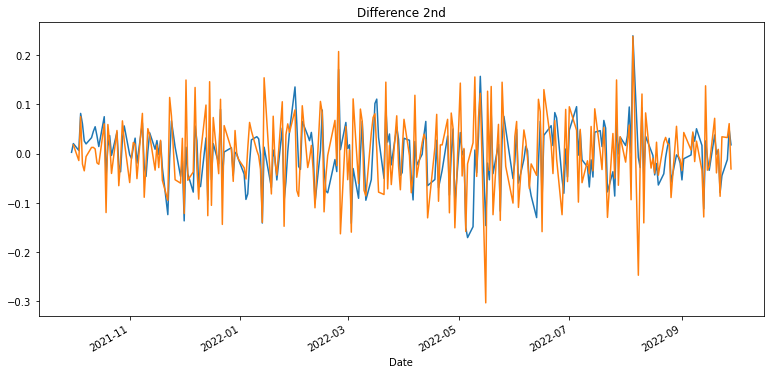

In [221]:
# 1차 차분 구하기
diff_1 = ts_cf_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## Step6. ARIMA 모델 훈련과 테스트

In [237]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 10))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(0, 1, 10)   Log Likelihood                -721.805
Date:                Fri, 30 Sep 2022   AIC                           1465.611
Time:                        13:28:27   BIC                           1503.188
Sample:                             0   HQIC                          1480.777
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0782      0.071      1.102      0.271      -0.061       0.217
ma.L2          0.0026      0.065      0.041      0.968      -0.124       0.129
ma.L3         -0.0160      0.075     -0.214      0.8

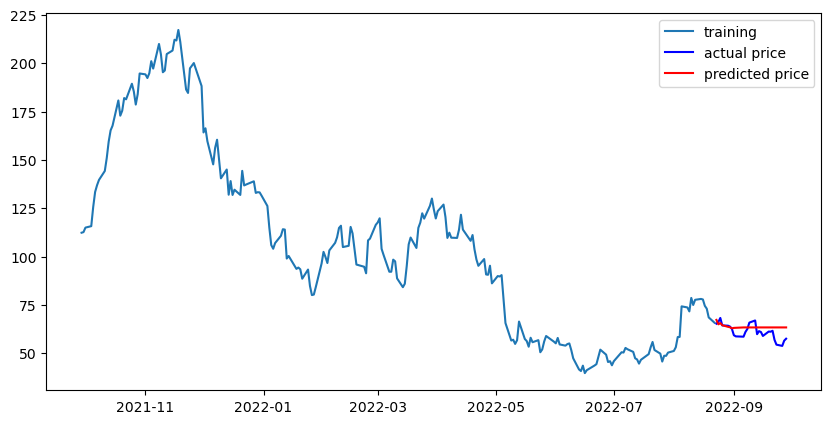

In [238]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [247]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7.549791302558314e+57
MAE:  3.0084587170507494e+28
RMSE:  8.688953505778653e+28
MAPE: 92121.11%


order = (21,1,0)을 넣으면, 평균오차율이 13.31%가 나왔다. 
order = (21,1,2)을 넣으면 13.9%가 나왔다.

LMS에서 배운것처럼 p와 q 한쪽에 0을 넣는게 더 잘 나왔다.

order = (0,1,2)를 넣어봤더니 예측결과가 시간에 선형으로 비례하는 경향이 강해졌다.
오차율은 7.64%로 낮아졌다.

모든 결과가 시장가격이 유지될거라 봤지만 실제론 감소했다.

다시 보니, 전체적으로 하락을 하고 있기에 로그변환을 하지 않고 다시 해보자.

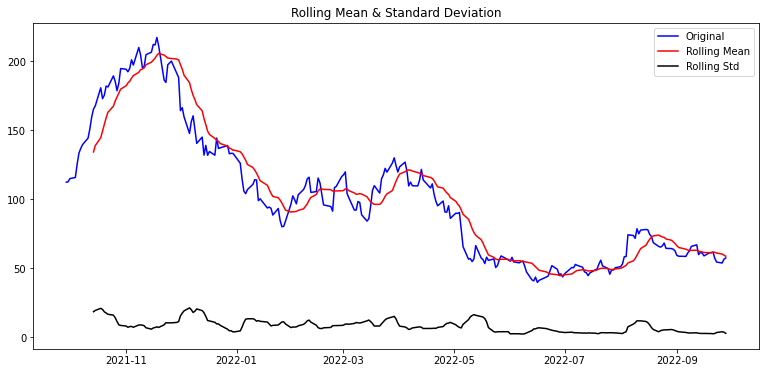

Results of Dickey-Fuller Test:
Test Statistic                  -0.790077
p-value                          0.822020
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


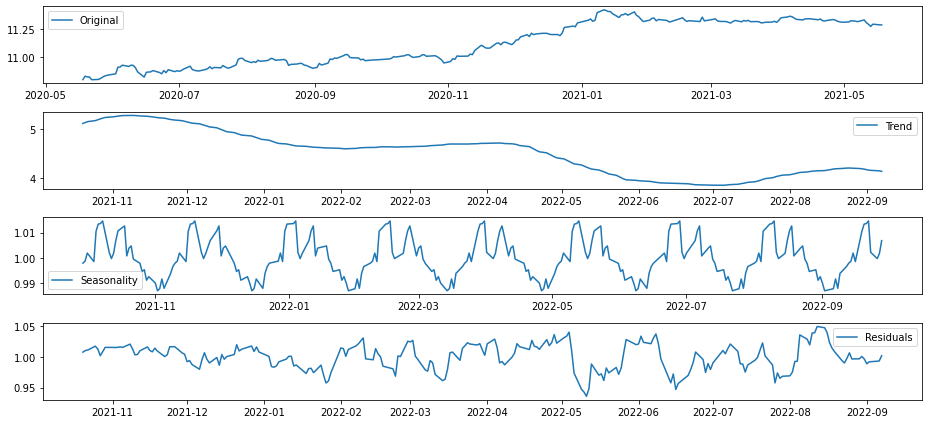

In [225]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_cf, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_cf)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_cf_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [226]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.538145
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


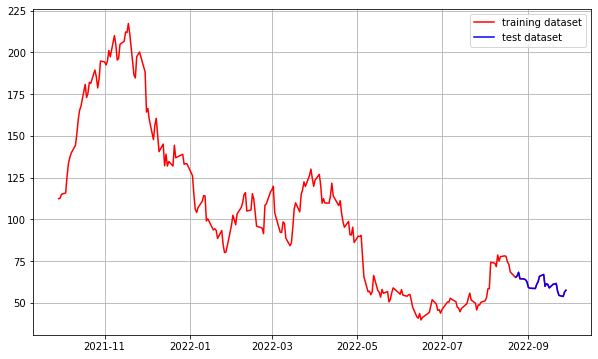

In [227]:
train_data, test_data = ts_cf[:int(len(ts_cf)*0.9)], ts_cf[int(len(ts_cf)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_cf, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

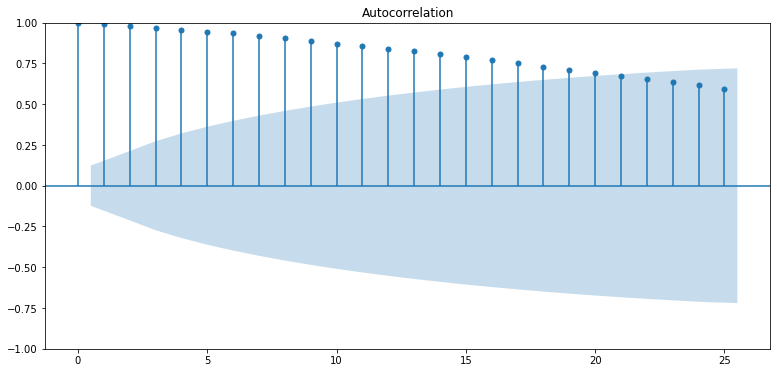

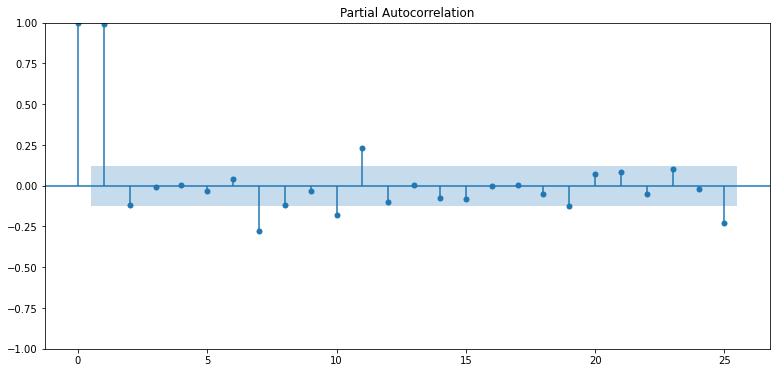

In [228]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_cf)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_cf)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.700251
p-value                          0.000084
#Lags Used                       9.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.521214e+00
p-value                        3.786469e-11
#Lags Used                     1.000000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


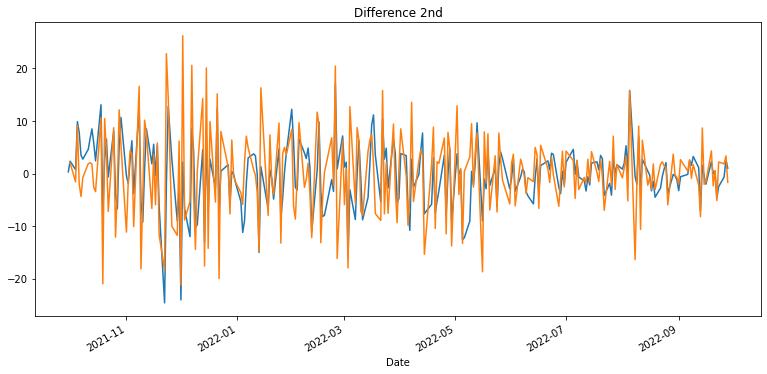

In [229]:

# 1차 차분 구하기
diff_1 = ts_cf.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [275]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 7))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 7)   Log Likelihood                -724.466
Date:                Fri, 30 Sep 2022   AIC                           1464.932
Time:                        13:38:25   BIC                           1492.260
Sample:                             0   HQIC                          1475.962
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0756      0.071      1.068      0.286      -0.063       0.214
ma.L2         -0.0230      0.060     -0.381      0.703      -0.142       0.095
ma.L3         -0.0253      0.072     -0.350      0.7

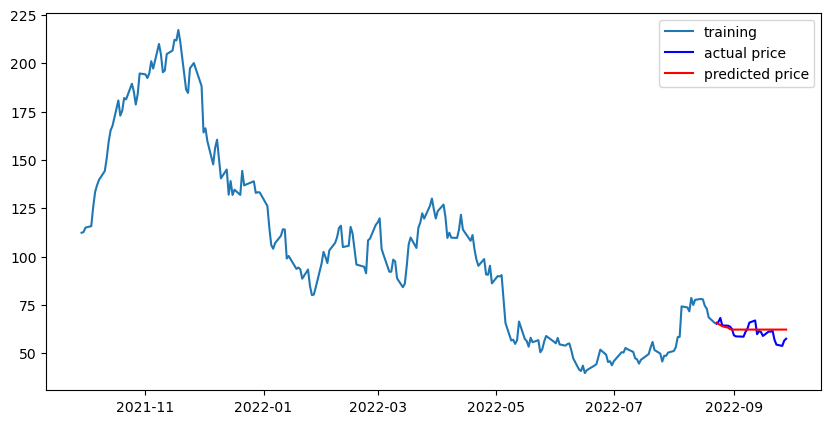

In [276]:

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [277]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)

mape = np.mean((np.abs(fc) - test_data)/np.abs(test_data))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12.519636634692887
MAE:  2.7200190728540217
RMSE:  3.53830985566455
MAPE: 2.70%


ACF에서 q를, PACF에서 p를 얻는다고 하는데 처음에 로그변환 시도에서는 반대로 해석해서 오차가 컸다.

이번에는 제대로 넣어보니 오차가 줄었다.

가장 좋다고 나온 21을 넣었더니 7.7%정도 나온다.

ARIMA 테이블을 보고 p>|Z|값이 가장 낮은 것인 6을 넣었더니 3.2%가 나왔고, 그 옆에 7을 넣으니 2.7%가 나왔다.



# 애플의 주식을 예측해보자.

## Step1. 데이터 불러오기


In [233]:
df_appl = pd.read_csv('./data/AAPL.csv', index_col= "Date", parse_dates=True)

ts_appl = df_appl['Close']

ts_appl.head()

Date
2021-09-29    142.830002
2021-09-30    141.500000
2021-10-01    142.649994
2021-10-04    139.139999
2021-10-05    141.110001
Name: Close, dtype: float64

## Step2. 각종 전처리

### 결측치 처리

In [234]:
ts_appl = ts_appl.interpolate(method='time')
ts_appl[ts_appl.isna()].sum()

0.0

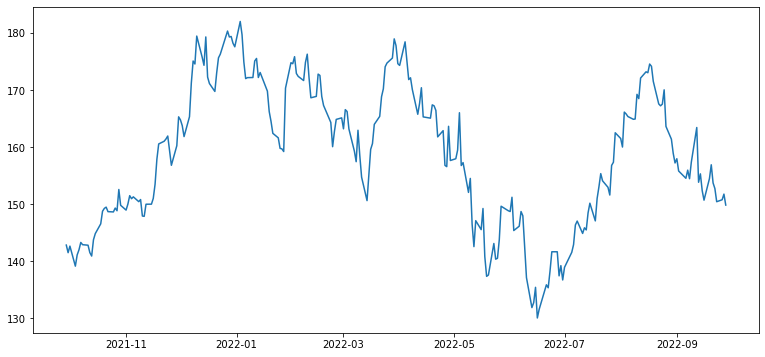

In [235]:
fig, ax = plt.subplots(1,1)

ax.plot(ts_appl)
plt.show()

### 로그변환

In [278]:
ts_log_appl = np.log(ts_appl)

## Step3. 시계열 안정성 분석

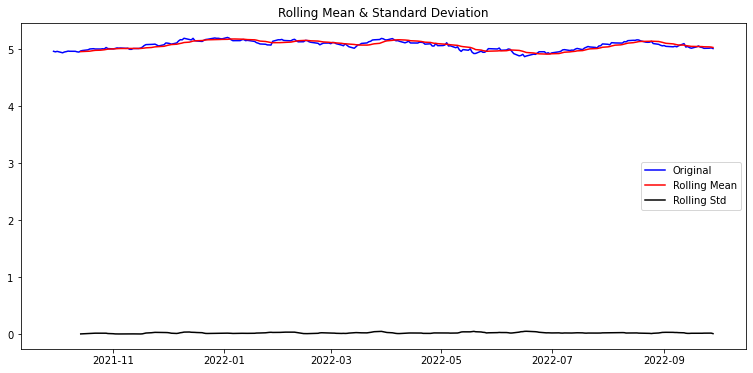

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


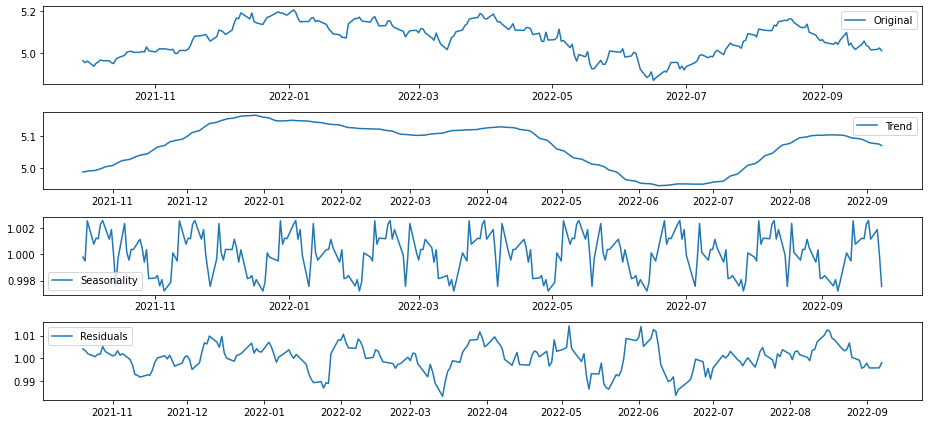

In [279]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_appl, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log_appl, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log_appl, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

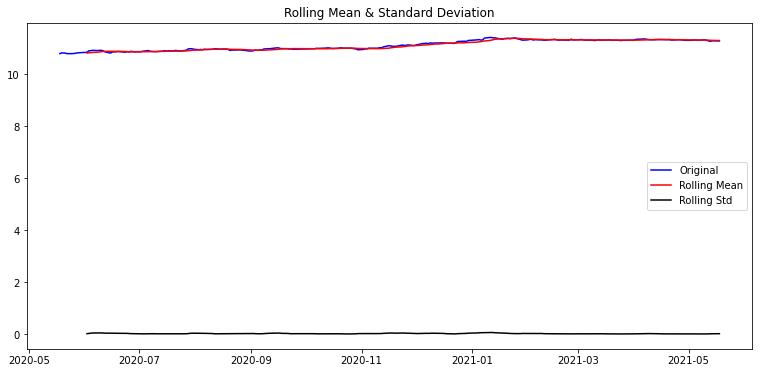

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


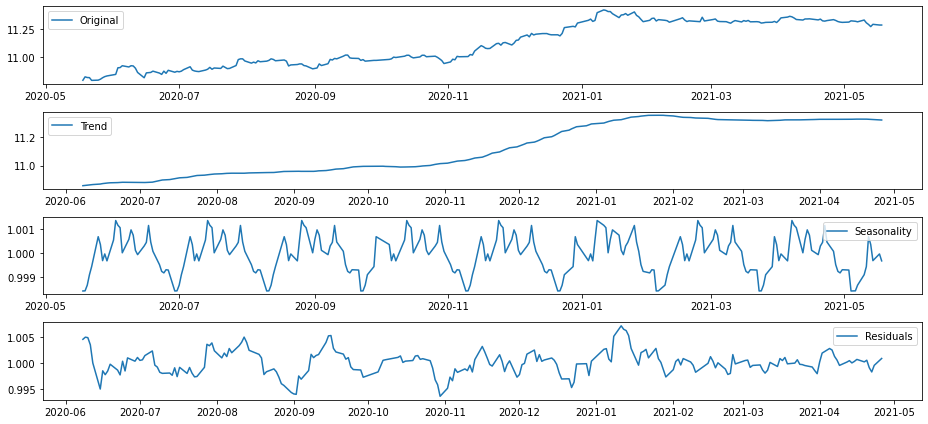

In [280]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [281]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### Train, Test 데이터셋 생성


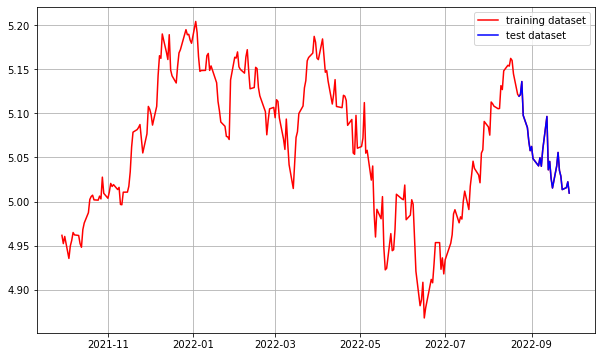

In [302]:
train_data, test_data = ts_log_appl[:int(len(ts_log_appl)*0.9)], ts_log_appl[int(len(ts_log_appl)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_appl, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

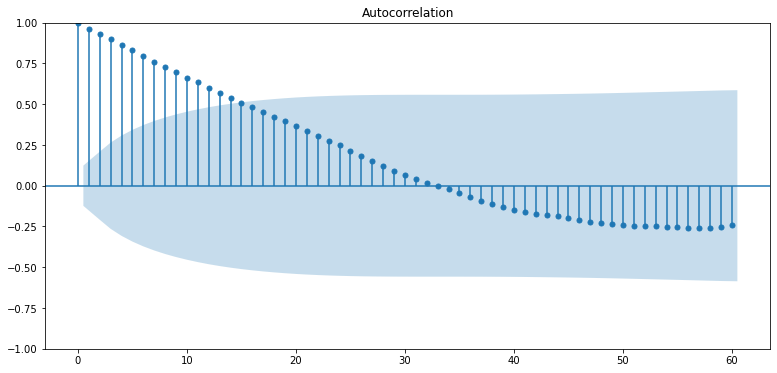

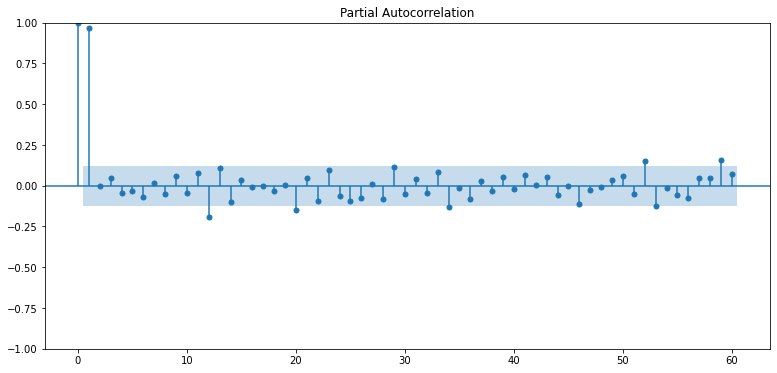

In [330]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_appl, lags=60)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_appl,lags=60)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.605511e+01
p-value                        5.718543e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.956005e+00
p-value                        3.036156e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


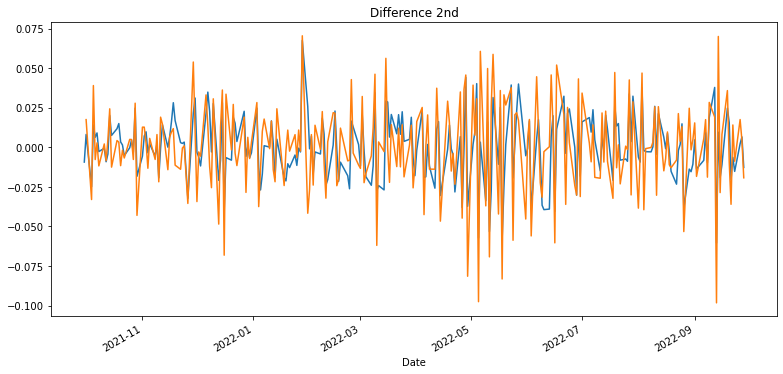

In [304]:
# 1차 차분 구하기
diff_1 = ts_log_appl.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### Step6. ARIMA 모델훈련과 테스트

In [338]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 0, 14))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                ARIMA(0, 0, 14)   Log Likelihood                 567.515
Date:                Fri, 30 Sep 2022   AIC                          -1103.030
Time:                        16:51:32   BIC                          -1048.302
Sample:                             0   HQIC                         -1080.944
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0654      0.015    329.208      0.000       5.035       5.096
ma.L1          1.0994      0.066     16.548      0.000       0.969       1.230
ma.L2          0.9927      0.090     11.059      0.0

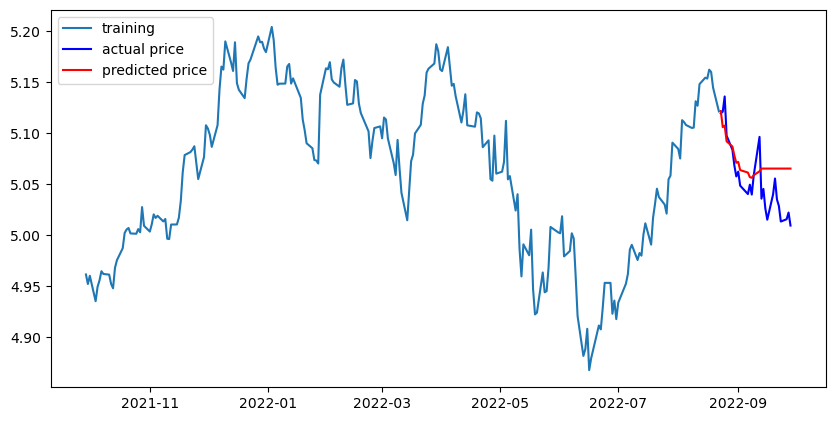

In [339]:

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [340]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  20.591786461613278
MAE:  3.7522479528288946
RMSE:  4.5378173675913045
MAPE: 2.43%


유의영역에 처음 들어오는 order(0,1,14)의 경우, 7.52%가 나온다.

p>|z|낮은 ar과 ma 값을 넣어보니, 7.49%가 나온다.

차분을 0으로 두었더니, 2.43%까지 내려간다. 아마도 계절성이 적어서 그러지 않을까 싶다.

lags=60으로 늘려서 0에 겹치는 부분까지 찾아봤다.

order = (0,0,34)로 넣어주니 4.26%이 나왔다.

유의영역에 다을 때 찾은 것이 더 훌륭한 정확도를 보였다.

# 회고

모델을 쓰는 방법은 어렵지 않았지만, ARIMA 모델의 모수를 찾는 정확한 방법을 알지 못해서, 여러가지 테스트를 했다.

'주가'를 예측하는데 시계열의 ARIMA 모델이 좋은 건지 어려웠다.
그리고 p와 q가 365일 데이터에서 13 12정도만 해도 거시적인 흐름들을 반영할 수 있는건지도 궁금했다.

# 공부한 내용 정리

## 시계열 데이터 분석

- 시계열 데이터를 분석하기 위해서 pd.serise로 만들어주었다. 하지만 index에 time 값을 설정해주어야 한다.
- 그러기 위해서 csv에서 읽어내면서 time 컬럼을 찾아서 index_col에 설정해주었다.
- 그 다음에 price 컬럼을 추출해서 시리즈를 선언해주면 된다.

우리는 시간에 대해서 훈련모델에 넣고 라벨값으로 출력해야하는 모델을 만들었다.

과거에서 일정한 패턴을 발견하기 위해서 시계열데이터가 안정적인지 알아봤다.

## 안정적 데이터, stationary

stationary data는
- 시간에 따른 일정한 평균, 표준편차를 가지며,
- 계절적 요인이 없어야 한다.

단위근이 없어야 하는데 아래와 같은 단위근은 특정 방법으로 상쇄시키면, stationary데이터라 볼 수 있다.

- 시간에 따라 일정하게 증가하거나 감소하는 거시적인 트랜드
- 계절이나 주기에 따라 반복되는 계절성의 일정한 패턴

d_t가 일정하다면 stationary 데이터와  같이 평균은 0이며 분산도 일정하다.
트랜드나 계절성을 가진 시계열데이터도 일정한 단위근을 제거하면, 미래의 시계열 데이터를 예측해볼 수 있다.

## AR, Autoregressive 모델

p 간격 떨어진 과거 데이터부터 직전의 데이터까지를 파라미터로 한 회귀모델을 학습시킨다.

## MA, MovingAverage 모델

전체 시계열 데이터 평균값에서, q 간격 떨어진 과거 데이터들의 오차들을 모두 더해준 것으로 구하는 것들이다.

## Augmented Dicky-Fuller Test

- AR, MA 등 시계열 분석을 하기 위해서는, stationary 상태를 확인해야한다.
- 단위근이 있는 시계열은 stationary하지 않기에
- 단위근이 있는 시계열이라는 귀무가설을 버릴 수 있는 지 검사한다.
- p-value가 0.05이하의 값이 나오면 stationary 하다고 한다.

## ARIMA 모델

- ARIMA는 AR(p), 차분(d), MA(q)에 대한 모수들을 파라미터로 설정해서 시계열 데이터를 분석하고 예측한다.
- 이러한 모수를 탐색하기 위해서 ACF와 PACF를 사용한다.

## ACF

- q 동안 연속적인 곳들의 상관계수들을 구한다.
- 평균값이 0.025안에 들어오는 q를 찾으면 95% 이상의 확률로 stationary하다고 처리한다.

## PACF

- p 간격 떨어진 곳(lagged)과의 부분 상관계수를 구한다.
- 0.025 안에 들어오는 p를 찾으면 stationary하다고 처리한다.